### Dataset loading and data cleansing

In [2]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

retail_df = pd.read_excel('./UCI_online_retail_data/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [3]:
retail_df.shape

(541909, 8)

In [4]:
# Customer segmentation -> customerID is a must -> drop the data without customer ID
# drop the cancel order (InvoiceNo start with 'C', and negative quantity and negative price)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
retail_df['Country'].value_counts()

United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [7]:
# take only UK cases
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM (Recency, Frequency, Monetary Value) based data preprocessing

In [8]:
retail_df['sale_amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [12]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False).head(5))

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [13]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count()

InvoiceNo  StockCode
536365     21730        1
           22752        1
           71053        1
           84029E       1
           84029G       1
                       ..
581585     84946        1
581586     20685        1
           21217        1
           22061        1
           23275        1
Name: InvoiceNo, Length: 344435, dtype: int64

In [14]:
# InvoicNo + StockCode -> work as identifier
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

In [15]:
retail_df['InvoiceNo'].value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
548940      1
562050      1
579015      1
548985      1
559677      1
Name: InvoiceNo, Length: 16646, dtype: int64

In [35]:
# RFM segmentation -> Customer level
# DataFrame groupby() multiple operation -> agg()
# Recency -> max() to InvoiceDate column 
# Frequency -> count() to InvoiceNo column
# Monetary value -> sum() to sale_amount column
aggregations = {'InvoiceDate':'max',
                'InvoiceNo':'count',
                'sale_amount':'sum'}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)

# rename columns
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency', 
                                    'InvoiceNo':'Frequency', 
                                    'sale_amount':'Monetary'})
cust_df.head(3)

,Recency,Frequency,Monetary
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73


In [36]:
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [37]:
# 2010/12/1 ~ 2010/12/9 data -> today: 2010/12/10
import datetime as dt
dt.datetime(2011,12,10)-cust_df['Recency']

0      325 days 13:59:00
1        2 days 09:26:00
2        0 days 11:40:00
3        3 days 14:04:00
4        3 days 08:48:00
              ...       
3915   277 days 14:08:00
3916   180 days 13:07:00
3917     7 days 12:17:00
3918     3 days 11:58:00
3919    42 days 14:31:00
Name: Recency, Length: 3920, dtype: timedelta64[ns]

In [38]:
cust_df['Recency'] = dt.datetime(2011,12,10)-cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x:x.days)
print('cust_df shape', cust_df.shape)
cust_df.head(3)

cust_df shape (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,2,103,4196.01
2,12748,0,4595,33719.73


### Customer segmentation based on RFM

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

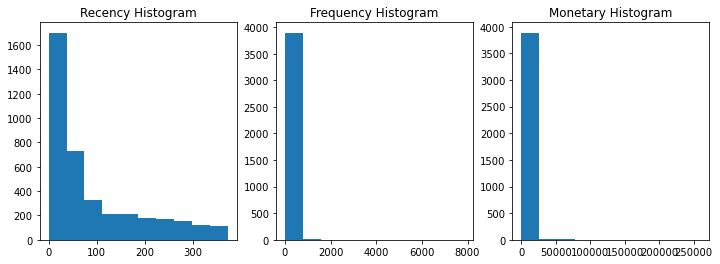

In [43]:
# immbalance data distribution
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [45]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,91.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,0.000000,1.000000,3.750000
25%,17.000000,17.000000,300.280000
50%,50.000000,41.000000,652.280000
75%,142.000000,99.250000,1576.585000
max,373.000000,7847.000000,259657.300000


* StandardScaler

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('Silouette score : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

Silouette score : 0.592


In [54]:
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    
    import matplotlib.cm as cm
    import math
    
    n_cols = len(cluster_lists)
    
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features)+(n_cluster+1)*10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower+size_cluster_i
            
            color = cm.nipy_spectral(float(i)/n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, 
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower+0.5*size_cluster_i, str(i))
            
            y_lower = y_upper+10
        
        axs[ind].axvline(x=sil_avg, color='red', linestyle='--')

In [66]:
### 2D plot after PCA dimension reduction
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    # set number of subplots
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize = (n_cols*4, 4), nrows=1, ncols=n_cols)
    # PCA -> 2 dimensional
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1', 'PCA2'])
    
    for ind, n_cluster in enumerate(cluster_lists):
        # KMeans clustering
        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster'] = cluster_labels
        unique_labels = np.unique(clusterer.labels_)
#         print(np.unique(clusterer.labels_))
#         print(np.unique(cluster_labels))
        markers = ['o', 's', '^', 'x', '*']
        
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else:
                cluster_legend = 'Cluster'+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, 
                             edgecolor='k', marker=markers[label], label=cluster_legend)
        
        axs[ind].set_title('Number of Cluster:'+str(n_cluster))
        axs[ind].legend(loc='upper right')
    
    plt.show()
    

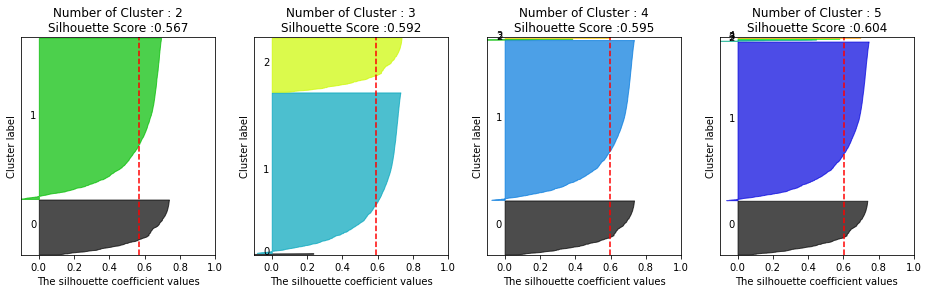

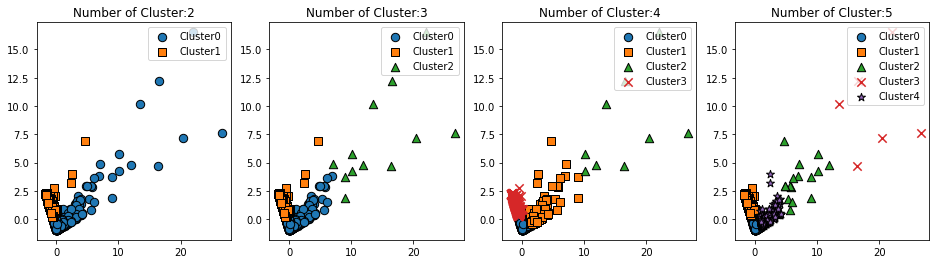

In [67]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

In [71]:
# apply log1p() to imbalanced data set
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# apply log1p()
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# apply StandardScaler()
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('Siluette score: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))


Siluette score: 0.306


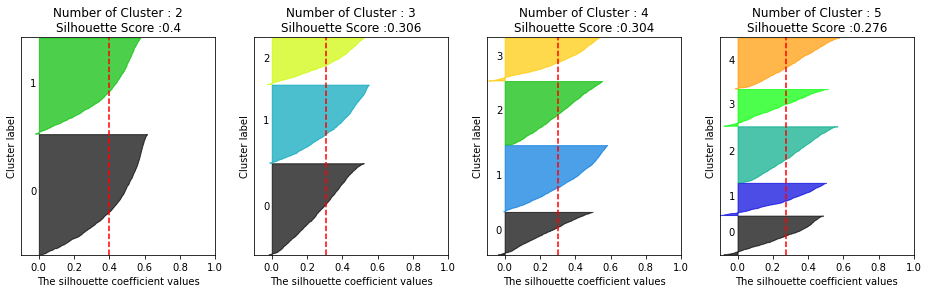

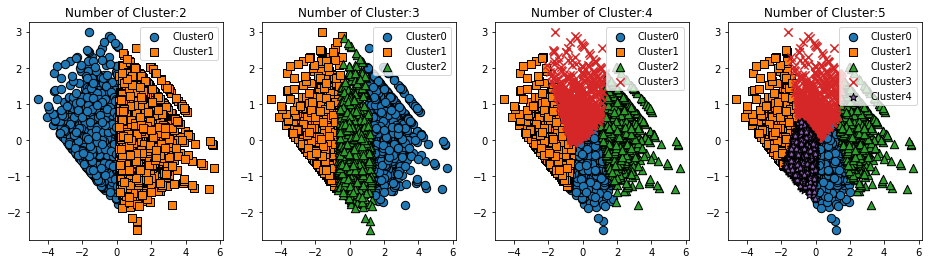

In [72]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

In [ ]:
# dat + 1 makes slightly different results